### Prerequisite Packages

In [1]:

import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

sys.path.append('../')

from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits
from modules.dataloader import load_npy_files
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [2]:
# Ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Worker seed function for DataLoader
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)

        return seed_worker

In [3]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

set_seed(42)  # Set global seed at the start

### Audio Feature selection: 'logmel' or 'mfcc'
selected_audio_feature = 'logmel'
audio_features_dir = get_audio_feature_path(selected_audio_feature)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

### Filter outliers in video features
lower_bound=35
upper_bound=197

### Hyperparameters
threshold = 0.5              # for predictions
num_epochs = 10              # for model training
cl_dropout_rate = 0.4        # for FinalClassifier

### LR Scheduler Parameters     
learning_rate = 1e-4      
decay_rate = 0.9  


### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits().to(device)
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

# Define the dimensions for GMU
text_dim = 1024  
audio_dim = 768 
video_dim = 768  
output_dim = 768 

## For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation


Device: cuda


### Dataset Class

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}
        
        # List to store missing files
        self.missing_files = []
        
        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']
        
        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping and ensure binary values
        label_map = {'red': 1.0, 'green': 0.0}
        
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [6]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [7]:
def filter_video_features(video_features, lower_bound=lower_bound, upper_bound=upper_bound):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


### Data Loading

In [8]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42), worker_init_fn=set_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### GMU Class

In [9]:
# Class for Gated Multimodal Unit of Arevalo et al. (2017)
class GatedMultimodalUnit(torch.nn.Module):
    def __init__(self, text_dim, audio_dim, video_dim, output_dim):
        super(GatedMultimodalUnit, self).__init__()
        
        # Linear transformation for text
        self.text_linear = LinearTransformations(text_dim, output_dim)
        
        # Convolutional layers for audio and video features
        self.audio_conv = nn.Conv1d(audio_dim, output_dim, kernel_size=1)
        self.video_conv = nn.Conv1d(video_dim, output_dim, kernel_size=1)
        
        self.output_dim = output_dim 
        
        # Activation functions
        self.activation = nn.Tanh()
        self.gate_activation = nn.Sigmoid()
        
        # Weight matrices for each modality
        self.W1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Gating matrices
        self.Y1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        
        # Initialize weight matrices
        init.xavier_uniform_(self.W1)
        init.xavier_uniform_(self.W2)
        init.xavier_uniform_(self.W3)
        
        # Initialize gating matrices
        init.xavier_uniform_(self.Y1)
        init.xavier_uniform_(self.Y2)
        init.xavier_uniform_(self.Y3)
        
        
    def forward(self, text_features, audio_features, video_features):

        # Process text features to match shape
        x_t = self.text_linear(text_features)              # Shape: [batch_size, output_dim]

        # Process audio features to match shape
        audio_features = audio_features.squeeze(1).permute(0, 2, 1)               # Shape: [batch_size, audio_dim, sequence_length] 
        x_a = self.audio_conv(audio_features).mean(dim=-1)              # Shape: [batch_size, output_dim]

        # Process video features to match shape
        video_features = video_features.permute(0, 2, 1)   # Shape: [batch_size, video_dim, sequence_length]
        x_v = self.video_conv(video_features).mean(dim=-1)              # Shape: [batch_size, output_dim]
 
        h1 = self.activation(torch.matmul(x_t, self.W1))        # Shape: [batch_size, output_dim]
        h2 = self.activation(torch.matmul(x_a, self.W2))        # Shape: [batch_size, output_dim]
        h3 = self.activation(torch.matmul(x_v, self.W3))        # Shape: [batch_size, output_dim]
        
        # Compute modality-specific gating weights
        z1 = self.gate_activation(torch.matmul(x_t, self.Y1))  # Shape: [batch_size, output_dim]
        z2 = self.gate_activation(torch.matmul(x_a, self.Y2))  # Shape: [batch_size, output_dim]
        z3 = self.gate_activation(torch.matmul(x_v, self.Y3))  # Shape: [batch_size, output_dim]
        
        # Calculate final output
        h = z1 * h1 + z2 * h2 + z3 * h3         

        return h


### Classifier

In [10]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(FinalClassifier, self).__init__()
        self.isBCELoss = isBCELoss

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.dense(x)
        if self.isBCELoss:
            x = self.sigmoid(x)
        return x

### Model Training Functions

In [11]:
def get_optimizer(parameters, lr=learning_rate):
    return optim.Adam(parameters, lr=lr)


In [12]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device, 
    output_dir='results/gmu/', 
    output_filename='train_predictions.csv',
):
    model.train()
    dense_layer.train()
    total_loss = 0.0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    results = []
    
    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        # Move all tensors to the same device as the model and criterion
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        video_features = video_features.to(device)
        targets = targets.view(-1).to(device)
        
        # Forward pass through GMU
        outputs = model(text_features, audio_features, video_features)

        # Forward pass through dense layer
        predictions = dense_layer(outputs).view(-1)
        
        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # # Apply sigmoid if not using BCELoss
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        # Get binary predictions
        binary_preds = (predictions >= threshold).float()
        
        # Store results
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': binary_preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics
        precision_metric.update(binary_preds.long(), targets.long())
        recall_metric.update(binary_preds.long(), targets.long())
        f1_metric.update(binary_preds.long(), targets.long())
        accuracy_metric.update(binary_preds.long(), targets.long())
        

    # Compute metrics
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()
    
    train_average_loss = total_loss / len(dataloader)
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [13]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/gmu/', 
    output_filename='val_predictions.csv',
):
    model.eval()
    dense_layer.eval()
    total_loss = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    results = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.view(-1).to(device)
            )
            

            # Forward passes
            outputs = model(text_features, audio_features, video_features)
            outputs = outputs.view(outputs.size(0), -1)
            
            predictions = dense_layer(outputs).view(-1)
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            
            # # Apply sigmoid if not using BCELoss
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)
            
            # Get binary predictions
            binary_preds = (predictions >= threshold).float()
            
            # Store predictions and targets for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Store results
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': binary_preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics
            precision_metric.update(binary_preds.long(), targets.long())
            recall_metric.update(binary_preds.long(), targets.long())
            f1_metric.update(binary_preds.long(), targets.long())
            accuracy_metric.update(binary_preds.long(), targets.long())
    
    # Compute metrics
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item()
    
    val_average_loss = total_loss / len(dataloader)
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [14]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/gmu/', 
    output_filename='test_predictions.csv',
):

    model.eval()
    dense_layer.eval()
    total_loss = 0

    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of testing
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    # List to collect results for CSV
    results = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Pass inputs through GMU model
            outputs = model(text_features, audio_features, video_features)
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]
            
            # Pass the GMU outputs through the dense layer to get final predictions
            predictions = dense_layer(outputs).view(-1)
            
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # # Apply sigmoid if BCELoss is not used
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            binary_preds = (predictions >= threshold).float()
            
            # Store predictions and targets for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Store results
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': binary_preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics
            precision_metric.update(binary_preds.long(), targets.long())
            recall_metric.update(binary_preds.long(), targets.long())
            f1_metric.update(binary_preds.long(), targets.long())
            accuracy_metric.update(binary_preds.long(), targets.long())
            

    # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item() 

    test_average_loss = total_loss / len(dataloader)

    # Calculate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)


    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix


### Model Training

In [15]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)  # Generate epoch numbers starting from 1
    plt.plot(epochs, train_losses, label='Training Loss', color='#1f77b4', linestyle='-', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='#ff7f0e', linestyle='-', marker='x')
    plt.title('Training and Validation Loss over Epochs')    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [17]:
if __name__ == "__main__":
    set_seed(42)
    
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    # Initialize the SMCA model A
    model = GatedMultimodalUnit(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim).to(device) 
    else:
        dense_layer = DenseLayer(output_dim).to(device)

    optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)
    
    scheduler = ExponentialLR(optimizer, gamma=decay_rate)
    
    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss

        print("-" * 20, "Train", "-" * 20)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}")
        print(f"Train F1 Score: {train_f1_score:.4f}")
        print(f"Train Loss: {train_average_loss:.4f}")
    
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
        val_losses.append(val_average_loss)  # Store validation loss
        
        print("-" * 20, "Eval", "-" * 20)
        print(f"Eval Accuracy: {val_accuracy:.4f}")
        print(f"Eval Precision: {val_precision:.4f}")
        print(f"Eval Recall: {val_recall:.4f}")
        print(f"Eval F1 Score: {val_f1_score:.4f}")
        print(f"Eval Loss: {val_average_loss:.4f}")
        
        # Update learning rate
        scheduler.step()

        # Log current learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Learning Rate after Epoch {epoch + 1}: {current_lr:.8f}")
        
    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    
    print("-" * 20, "Test", "-" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)

Device: cuda
----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.7346
Train Precision: 0.2273
Train Recall: 0.0214
Train F1 Score: 0.0391
Train Loss: 0.5976
-------------------- Eval --------------------
Eval Accuracy: 0.7487
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5561
Learning Rate after Epoch 1: 0.00009000
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.7476
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5433
-------------------- Eval --------------------
Eval Accuracy: 0.7487
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5208
Learning Rate after Epoch 2: 0.00008100
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.7487
Train Precision: 1.0000
Train Recall: 0.0043
Train F1 Score:

### Results Monitoring

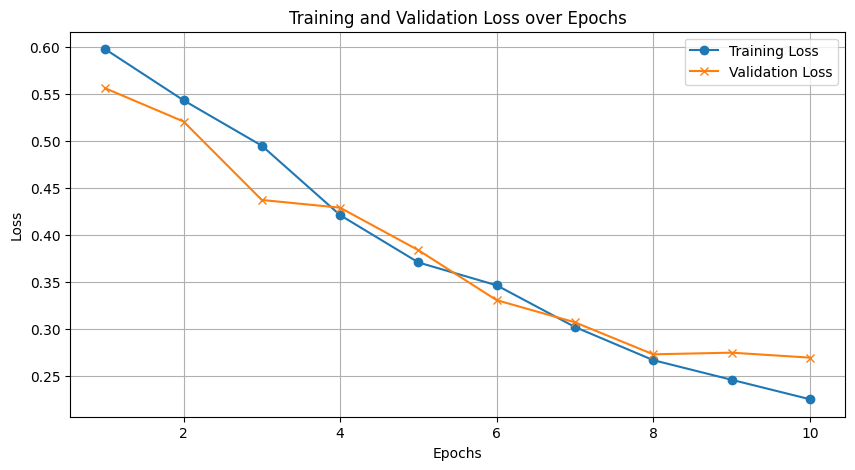

In [18]:
plot_losses(train_losses, val_losses)

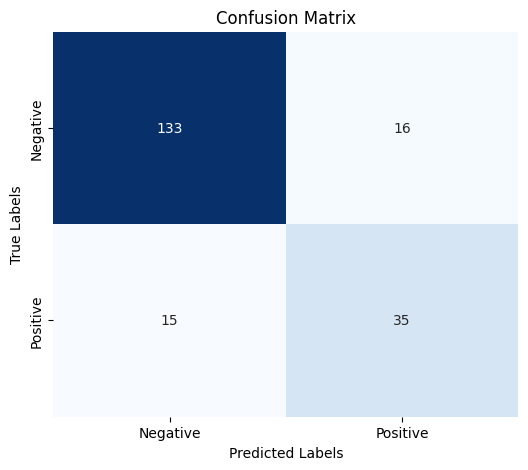

In [19]:
plot_confusion_matrix(test_conf_matrix)

In [20]:
# Display the table
metrics_df

,Train Accuracy,Validation Accuracy,Test Accuracy,Train Precision,Validation Precision,Test Precision,Train Recall,Validation Recall,Test Recall,Train F1 Score,Validation F1 Score,Test F1 Score,Train Loss,Validation Loss,Test Loss
0,0.919094,0.869347,0.844221,0.869767,0.75,0.686275,0.799145,0.72,0.7,0.832962,0.734694,0.693069,0.225399,0.269635,0.342293


### Cross-Validation

In [21]:
def plot_average_loss_curves(train_losses_folds, val_losses_folds):
    # Transpose folds to calculate averages and standard deviations per epoch
    num_epochs = len(train_losses_folds[0])
    
    # Calculate average and standard deviation for training losses
    avg_train_losses = [np.mean([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    std_train_losses = [np.std([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    
    # Calculate average and standard deviation for validation losses
    avg_val_losses = [np.mean([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]
    std_val_losses = [np.std([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]
    
    # Define the epochs
    epochs = range(1, num_epochs + 1)
    
    # Plotting
    plt.figure(figsize=(12, 7))
    
    # Plot average training loss with markers and shaded standard deviation
    plt.plot(epochs, avg_train_losses, label='Average Training Loss', color='#1f77b4', linewidth=2, marker='o')
    plt.fill_between(epochs, 
                     np.array(avg_train_losses) - np.array(std_train_losses), 
                     np.array(avg_train_losses) + np.array(std_train_losses), 
                     color='#1f77b4', alpha=0.2)
    
    # Plot average validation loss with markers and shaded standard deviation
    plt.plot(epochs, avg_val_losses, label='Average Validation Loss', color='#ff7f0e', linewidth=2, marker='o')
    plt.fill_between(epochs, 
                     np.array(avg_val_losses) - np.array(std_val_losses), 
                     np.array(avg_val_losses) + np.array(std_val_losses), 
                     color='#ff7f0e', alpha=0.2)
    
    # Add titles and labels
    plt.title('Average Training and Validation Loss Across Folds', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Highlight the minimum validation loss epoch
    min_val_epoch = np.argmin(avg_val_losses) + 1
    min_val_loss = avg_val_losses[min_val_epoch - 1]
    plt.scatter(min_val_epoch, min_val_loss, color='red', zorder=5)
    
    # Dynamically position the annotation text slightly above the marker
    text_offset = (max(avg_val_losses) - min(avg_val_losses)) * 0.05
    plt.text(min_val_epoch, min_val_loss + text_offset, 
             f'Min Val Loss: {min_val_loss:.4f}', 
             color='black', fontsize=12, ha='center')
    
    # Add legend
    plt.legend(fontsize=12, frameon=True, edgecolor='black')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [22]:
def visualize_kfold_distribution(fold_data, num_folds):

    training_color = "#3399ff"
    testing_color = "#ff9933"  

    plt.figure(figsize=(14, 7))
    
    for fold_idx, fold in enumerate(fold_data):
        for sample_idx, val in enumerate(fold):
            if val == 1:  
                plt.barh(fold_idx, width=1, left=sample_idx, color=training_color)
            elif val == -1:  
                plt.barh(fold_idx, width=1, left=sample_idx, color=testing_color)

    # Enhance plot aesthetics
    plt.title("K-Fold Training and Testing Set Distribution", fontsize=18, weight='bold', pad=20)
    plt.xlabel("Data Index", fontsize=14, labelpad=10)
    plt.ylabel("Fold", fontsize=14, labelpad=10)
    plt.yticks(range(num_folds), [f"Fold {i+1}" for i in range(num_folds)], fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Create a custom legend
    training_patch = mpatches.Patch(color=training_color, label='Training Set')
    testing_patch = mpatches.Patch(color=testing_color, label='Testing Set')
    plt.legend(handles=[training_patch, testing_patch], loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')
    
    plt.tight_layout()
    plt.show()

In [23]:
def print_cv_dataloader(dataloader, name="Dataloader"):
    total_samples = len(dataloader.sampler)
    num_batches = len(dataloader)
    print(f"{name}: Total Samples = {total_samples}, Number of Batches = {num_batches}")

In [24]:
def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs,
    text_dim,
    audio_dim,
    video_dim,
    output_dim,
    criterion,
    learning_rate,
    train_batch_size,
    val_batch_size,
    output_file,
    device=None
):
    
    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    
    # Lists to store metrics and losses for each fold
    train_losses_folds = []  # List of lists: train_losses_folds[fold][epoch]
    val_losses_folds = []    # List of lists: val_losses_folds[fold][epoch]
    
    # Visualization data structure
    num_samples = len(dataset)
    fold_data = np.zeros((num_folds, num_samples))  # Rows: folds, Columns: dataset samples
       
    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")
        
        # Set device configuration
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
        
        set_seed(42)  # Set global seed at the start
        
        # Mark train and test samples for visualization
        fold_data[fold, train_idx] = 1  # Training set
        fold_data[fold, val_idx] = -1  # Testing set
        
        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        print_cv_dataloader(train_dataloader, "Train DataLoader")
        print_cv_dataloader(val_dataloader, "Validation DataLoader")
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)
        
        dense_layer = dense_layer_class(output_dim).to(device)
        
        criterion = criterion.to(device)
        
        optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)
        
        scheduler = ExponentialLR(optimizer, gamma=decay_rate)

        # Initialize lists to track losses for this fold
        train_losses = []
        val_losses = []
        
        # Use tqdm for progress bar
        epoch_progress = tqdm(range(num_epochs), desc=f"Fold {fold + 1}/{num_folds} Training", leave=True)

        # Training loop for each fold
        for epoch in epoch_progress:
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            # Track losses for this fold and epoch
            train_losses.append(train_average_loss)
            val_losses.append(val_average_loss)
            
            print(f"\nTrain Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision: {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 Score: {train_f1_score:.4f}")
            print(f"Train Loss: {train_average_loss:.4f}")
            
            print(f"\nEval Accuracy: {val_accuracy:.4f}")
            print(f"Eval Precision: {val_precision:.4f}")   
            print(f"Eval Recall: {val_recall:.4f}")
            print(f"Eval F1 Score: {val_f1_score:.4f}")
            print(f"Eval Loss: {val_average_loss:.4f}")
            
            # Update learning rate
            scheduler.step()

            # Log current learning rate
            current_lr = scheduler.get_last_lr()[0]
            print(f"Learning Rate after Epoch {epoch + 1}: {current_lr:.8f}")
            
            # Update tqdm progress bar description
            epoch_progress.set_postfix({
                "Train Loss": f"{train_average_loss:.4f}",
                "Val Loss": f"{val_average_loss:.4f}",
                "Train F1": f"{train_f1_score:.4f}",
                "Val F1": f"{val_f1_score:.4f}",
            })
        
        # Store losses for the fold
        train_losses_folds.append(train_losses)
        val_losses_folds.append(val_losses)
           
        # Store the validation metrics for this fold
        fold_losses.append(val_average_loss)
        fold_accuracies.append(val_accuracy)
        fold_precisions.append(val_precision)
        fold_recalls.append(val_recall)
        fold_f1_scores.append(val_f1_score)

    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    results_dict = {"Metrics": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"]}
    for i in range(num_folds):
        results_dict[f"Fold {i + 1}"] = [fold_losses[i], fold_accuracies[i], fold_precisions[i], fold_recalls[i], fold_f1_scores[i]]
    results_dict["Average"] = [avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score]

    # Create DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  
        
    # Save results to .csv
    results_df.to_csv(output_file, index=False)
    
    return results_df, train_losses_folds, val_losses_folds, fold_data

In [25]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer

# Run k-fold cross-validation   
results_df, train_losses_folds, val_losses_folds, fold_data = cross_validate_model(
    dataset=full_dataset,
    model_class=GatedMultimodalUnit,
    dense_layer_class=dense_layer_class,
    criterion=criterion,
    text_dim=text_dim,
    audio_dim=audio_dim,
    video_dim=video_dim,
    output_dim=output_dim,
    num_epochs=num_epochs_cv,    
    num_folds=num_folds,
    train_batch_size=train_batch_size,
    val_batch_size=val_batch_size,
    learning_rate=learning_rate,
    output_file=f'results/gmu/GMU-CV_scores.csv'
)

------------------------------------------------------------
------------------------- Fold 1/5 -------------------------
Device: cuda
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 1/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 1/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.34s/it, Train Loss=0.5669, Val Loss=0.5617, Train F1=0.0341, Val F1=0.0000]


Train Accuracy: 0.7330
Train Precision: 0.1786
Train Recall: 0.0189
Train F1 Score: 0.0341
Train Loss: 0.5669

Eval Accuracy: 0.7396
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5617
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 1/5 Training:  20%|██        | 2/10 [00:02<00:10,  1.35s/it, Train Loss=0.5194, Val Loss=0.5096, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7500
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5194

Eval Accuracy: 0.7396
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5096
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 1/5 Training:  30%|███       | 3/10 [00:04<00:09,  1.36s/it, Train Loss=0.4301, Val Loss=0.4581, Train F1=0.2830, Val F1=0.3736]


Train Accuracy: 0.7896
Train Precision: 0.9565
Train Recall: 0.1660
Train F1 Score: 0.2830
Train Loss: 0.4301

Eval Accuracy: 0.7849
Eval Precision: 0.7727
Eval Recall: 0.2464
Eval F1 Score: 0.3736
Eval Loss: 0.4581
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 1/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.36s/it, Train Loss=0.3625, Val Loss=0.4450, Train F1=0.6514, Val F1=0.6525]


Train Accuracy: 0.8566
Train Precision: 0.8304
Train Recall: 0.5358
Train F1 Score: 0.6514
Train Loss: 0.3625

Eval Accuracy: 0.8151
Eval Precision: 0.6389
Eval Recall: 0.6667
Eval F1 Score: 0.6525
Eval Loss: 0.4450
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 1/5 Training:  50%|█████     | 5/10 [00:06<00:06,  1.35s/it, Train Loss=0.3065, Val Loss=0.4378, Train F1=0.7250, Val F1=0.6625]


Train Accuracy: 0.8755
Train Precision: 0.8093
Train Recall: 0.6566
Train F1 Score: 0.7250
Train Loss: 0.3065

Eval Accuracy: 0.7962
Eval Precision: 0.5824
Eval Recall: 0.7681
Eval F1 Score: 0.6625
Eval Loss: 0.4378
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 1/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.32s/it, Train Loss=0.2811, Val Loss=0.4271, Train F1=0.7821, Val F1=0.5714]


Train Accuracy: 0.8943
Train Precision: 0.8072
Train Recall: 0.7585
Train F1 Score: 0.7821
Train Loss: 0.2811

Eval Accuracy: 0.8189
Eval Precision: 0.7442
Eval Recall: 0.4638
Eval F1 Score: 0.5714
Eval Loss: 0.4271
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 1/5 Training:  70%|███████   | 7/10 [00:09<00:04,  1.44s/it, Train Loss=0.2563, Val Loss=0.4160, Train F1=0.7807, Val F1=0.6000]


Train Accuracy: 0.8972
Train Precision: 0.8362
Train Recall: 0.7321
Train F1 Score: 0.7807
Train Loss: 0.2563

Eval Accuracy: 0.8340
Eval Precision: 0.8049
Eval Recall: 0.4783
Eval F1 Score: 0.6000
Eval Loss: 0.4160
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 1/5 Training:  80%|████████  | 8/10 [00:11<00:02,  1.42s/it, Train Loss=0.2319, Val Loss=0.3974, Train F1=0.8144, Val F1=0.6772]


Train Accuracy: 0.9123
Train Precision: 0.8644
Train Recall: 0.7698
Train F1 Score: 0.8144
Train Loss: 0.2319

Eval Accuracy: 0.8453
Eval Precision: 0.7414
Eval Recall: 0.6232
Eval F1 Score: 0.6772
Eval Loss: 0.3974
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 1/5 Training:  90%|█████████ | 9/10 [00:12<00:01,  1.40s/it, Train Loss=0.2122, Val Loss=0.3870, Train F1=0.8224, Val F1=0.6721]


Train Accuracy: 0.9160
Train Precision: 0.8729
Train Recall: 0.7774
Train F1 Score: 0.8224
Train Loss: 0.2122

Eval Accuracy: 0.8491
Eval Precision: 0.7736
Eval Recall: 0.5942
Eval F1 Score: 0.6721
Eval Loss: 0.3870
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 1/5 Training: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it, Train Loss=0.1974, Val Loss=0.3908, Train F1=0.8713, Val F1=0.7067]



Train Accuracy: 0.9387
Train Precision: 0.9167
Train Recall: 0.8302
Train F1 Score: 0.8713
Train Loss: 0.1974

Eval Accuracy: 0.8340
Eval Precision: 0.6543
Eval Recall: 0.7681
Eval F1 Score: 0.7067
Eval Loss: 0.3908
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 2/5 -------------------------
Device: cuda
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 2/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 2/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.39s/it, Train Loss=0.5659, Val Loss=0.5450, Train F1=0.0673, Val F1=0.0000]


Train Accuracy: 0.7387
Train Precision: 0.3704
Train Recall: 0.0370
Train F1 Score: 0.0673
Train Loss: 0.5659

Eval Accuracy: 0.7585
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5450
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 2/5 Training:  20%|██        | 2/10 [00:03<00:12,  1.52s/it, Train Loss=0.5137, Val Loss=0.4924, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7453
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5137

Eval Accuracy: 0.7585
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.4924
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 2/5 Training:  30%|███       | 3/10 [00:04<00:10,  1.43s/it, Train Loss=0.4277, Val Loss=0.4364, Train F1=0.3522, Val F1=0.4694]


Train Accuracy: 0.7953
Train Precision: 0.9077
Train Recall: 0.2185
Train F1 Score: 0.3522
Train Loss: 0.4277

Eval Accuracy: 0.8038
Eval Precision: 0.6765
Eval Recall: 0.3594
Eval F1 Score: 0.4694
Eval Loss: 0.4364
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 2/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.35s/it, Train Loss=0.3531, Val Loss=0.4220, Train F1=0.6989, Val F1=0.5333]


Train Accuracy: 0.8651
Train Precision: 0.8098
Train Recall: 0.6148
Train F1 Score: 0.6989
Train Loss: 0.3531

Eval Accuracy: 0.8151
Eval Precision: 0.6829
Eval Recall: 0.4375
Eval F1 Score: 0.5333
Eval Loss: 0.4220
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 2/5 Training:  50%|█████     | 5/10 [00:06<00:06,  1.31s/it, Train Loss=0.3056, Val Loss=0.4082, Train F1=0.7480, Val F1=0.5738]


Train Accuracy: 0.8811
Train Precision: 0.8130
Train Recall: 0.6926
Train F1 Score: 0.7480
Train Loss: 0.3056

Eval Accuracy: 0.8038
Eval Precision: 0.6034
Eval Recall: 0.5469
Eval F1 Score: 0.5738
Eval Loss: 0.4082
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 2/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.31s/it, Train Loss=0.2585, Val Loss=0.4037, Train F1=0.8177, Val F1=0.5946]


Train Accuracy: 0.9104
Train Precision: 0.8486
Train Recall: 0.7889
Train F1 Score: 0.8177
Train Loss: 0.2585

Eval Accuracy: 0.8302
Eval Precision: 0.7021
Eval Recall: 0.5156
Eval F1 Score: 0.5946
Eval Loss: 0.4037
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 2/5 Training:  70%|███████   | 7/10 [00:09<00:03,  1.32s/it, Train Loss=0.2383, Val Loss=0.4082, Train F1=0.8016, Val F1=0.5882]


Train Accuracy: 0.9057
Train Precision: 0.8632
Train Recall: 0.7481
Train F1 Score: 0.8016
Train Loss: 0.2383

Eval Accuracy: 0.8415
Eval Precision: 0.7895
Eval Recall: 0.4688
Eval F1 Score: 0.5882
Eval Loss: 0.4082
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 2/5 Training:  80%|████████  | 8/10 [00:10<00:02,  1.30s/it, Train Loss=0.1969, Val Loss=0.4125, Train F1=0.8533, Val F1=0.6176]


Train Accuracy: 0.9283
Train Precision: 0.8911
Train Recall: 0.8185
Train F1 Score: 0.8533
Train Loss: 0.1969

Eval Accuracy: 0.8038
Eval Precision: 0.5833
Eval Recall: 0.6562
Eval F1 Score: 0.6176
Eval Loss: 0.4125
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 2/5 Training:  90%|█████████ | 9/10 [00:12<00:01,  1.35s/it, Train Loss=0.1868, Val Loss=0.4066, Train F1=0.8609, Val F1=0.6504]


Train Accuracy: 0.9302
Train Precision: 0.8740
Train Recall: 0.8481
Train F1 Score: 0.8609
Train Loss: 0.1868

Eval Accuracy: 0.8377
Eval Precision: 0.6780
Eval Recall: 0.6250
Eval F1 Score: 0.6504
Eval Loss: 0.4066
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 2/5 Training: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it, Train Loss=0.1704, Val Loss=0.4383, Train F1=0.8795, Val F1=0.6331]



Train Accuracy: 0.9406
Train Precision: 0.9091
Train Recall: 0.8519
Train F1 Score: 0.8795
Train Loss: 0.1704

Eval Accuracy: 0.8075
Eval Precision: 0.5867
Eval Recall: 0.6875
Eval F1 Score: 0.6331
Eval Loss: 0.4383
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 3/5 -------------------------
Device: cuda
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 3/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 3/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.34s/it, Train Loss=0.5734, Val Loss=0.5702, Train F1=0.0283, Val F1=0.0000]


Train Accuracy: 0.7406
Train Precision: 0.1600
Train Recall: 0.0155
Train F1 Score: 0.0283
Train Loss: 0.5734

Eval Accuracy: 0.7132
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5702
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 3/5 Training:  20%|██        | 2/10 [00:02<00:10,  1.28s/it, Train Loss=0.5279, Val Loss=0.5369, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7566
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5279

Eval Accuracy: 0.7132
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5369
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 3/5 Training:  30%|███       | 3/10 [00:03<00:09,  1.31s/it, Train Loss=0.4813, Val Loss=0.4429, Train F1=0.0077, Val F1=0.3918]


Train Accuracy: 0.7575
Train Precision: 1.0000
Train Recall: 0.0039
Train F1 Score: 0.0077
Train Loss: 0.4813

Eval Accuracy: 0.7774
Eval Precision: 0.9048
Eval Recall: 0.2500
Eval F1 Score: 0.3918
Eval Loss: 0.4429
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 3/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.36s/it, Train Loss=0.4084, Val Loss=0.3822, Train F1=0.5326, Val F1=0.6610]


Train Accuracy: 0.8311
Train Precision: 0.8160
Train Recall: 0.3953
Train F1 Score: 0.5326
Train Loss: 0.4084

Eval Accuracy: 0.8491
Eval Precision: 0.9286
Eval Recall: 0.5132
Eval F1 Score: 0.6610
Eval Loss: 0.3822
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 3/5 Training:  50%|█████     | 5/10 [00:06<00:06,  1.38s/it, Train Loss=0.3485, Val Loss=0.3414, Train F1=0.6544, Val F1=0.7482]


Train Accuracy: 0.8585
Train Precision: 0.8068
Train Recall: 0.5504
Train F1 Score: 0.6544
Train Loss: 0.3485

Eval Accuracy: 0.8679
Eval Precision: 0.8254
Eval Recall: 0.6842
Eval F1 Score: 0.7482
Eval Loss: 0.3414
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 3/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.41s/it, Train Loss=0.3202, Val Loss=0.3310, Train F1=0.7158, Val F1=0.7632]


Train Accuracy: 0.8764
Train Precision: 0.8128
Train Recall: 0.6395
Train F1 Score: 0.7158
Train Loss: 0.3202

Eval Accuracy: 0.8642
Eval Precision: 0.7632
Eval Recall: 0.7632
Eval F1 Score: 0.7632
Eval Loss: 0.3310
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 3/5 Training:  70%|███████   | 7/10 [00:09<00:04,  1.40s/it, Train Loss=0.2707, Val Loss=0.3247, Train F1=0.7531, Val F1=0.7481]


Train Accuracy: 0.8868
Train Precision: 0.8026
Train Recall: 0.7093
Train F1 Score: 0.7531
Train Loss: 0.2707

Eval Accuracy: 0.8755
Eval Precision: 0.8909
Eval Recall: 0.6447
Eval F1 Score: 0.7481
Eval Loss: 0.3247
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 3/5 Training:  80%|████████  | 8/10 [00:10<00:02,  1.36s/it, Train Loss=0.2652, Val Loss=0.2906, Train F1=0.8008, Val F1=0.7733]


Train Accuracy: 0.9085
Train Precision: 0.8515
Train Recall: 0.7558
Train F1 Score: 0.8008
Train Loss: 0.2652

Eval Accuracy: 0.8717
Eval Precision: 0.7838
Eval Recall: 0.7632
Eval F1 Score: 0.7733
Eval Loss: 0.2906
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 3/5 Training:  90%|█████████ | 9/10 [00:12<00:01,  1.32s/it, Train Loss=0.2161, Val Loss=0.2985, Train F1=0.8320, Val F1=0.7883]


Train Accuracy: 0.9226
Train Precision: 0.8826
Train Recall: 0.7868
Train F1 Score: 0.8320
Train Loss: 0.2161

Eval Accuracy: 0.8906
Eval Precision: 0.8852
Eval Recall: 0.7105
Eval F1 Score: 0.7883
Eval Loss: 0.2985
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 3/5 Training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it, Train Loss=0.2058, Val Loss=0.2829, Train F1=0.8507, Val F1=0.7887]



Train Accuracy: 0.9311
Train Precision: 0.9004
Train Recall: 0.8062
Train F1 Score: 0.8507
Train Loss: 0.2058

Eval Accuracy: 0.8868
Eval Precision: 0.8485
Eval Recall: 0.7368
Eval F1 Score: 0.7887
Eval Loss: 0.2829
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 4/5 -------------------------
Device: cuda
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 4/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 4/5 Training:  10%|█         | 1/10 [00:01<00:13,  1.46s/it, Train Loss=0.5869, Val Loss=0.5231, Train F1=0.0271, Val F1=0.0000]


Train Accuracy: 0.7292
Train Precision: 0.1739
Train Recall: 0.0147
Train F1 Score: 0.0271
Train Loss: 0.5869

Eval Accuracy: 0.7660
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5231
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 4/5 Training:  20%|██        | 2/10 [00:02<00:11,  1.45s/it, Train Loss=0.5446, Val Loss=0.4950, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7434
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5446

Eval Accuracy: 0.7660
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.4950
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 4/5 Training:  30%|███       | 3/10 [00:04<00:10,  1.47s/it, Train Loss=0.4839, Val Loss=0.4273, Train F1=0.0430, Val F1=0.2286]


Train Accuracy: 0.7481
Train Precision: 0.8571
Train Recall: 0.0221
Train F1 Score: 0.0430
Train Loss: 0.4839

Eval Accuracy: 0.7962
Eval Precision: 1.0000
Eval Recall: 0.1290
Eval F1 Score: 0.2286
Eval Loss: 0.4273
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 4/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.46s/it, Train Loss=0.4187, Val Loss=0.3674, Train F1=0.4368, Val F1=0.4390]


Train Accuracy: 0.7981
Train Precision: 0.7685
Train Recall: 0.3051
Train F1 Score: 0.4368
Train Loss: 0.4187

Eval Accuracy: 0.8264
Eval Precision: 0.9000
Eval Recall: 0.2903
Eval F1 Score: 0.4390
Eval Loss: 0.3674
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 4/5 Training:  50%|█████     | 5/10 [00:07<00:07,  1.44s/it, Train Loss=0.3536, Val Loss=0.3247, Train F1=0.6781, Val F1=0.7480]


Train Accuracy: 0.8585
Train Precision: 0.8144
Train Recall: 0.5809
Train F1 Score: 0.6781
Train Loss: 0.3536

Eval Accuracy: 0.8830
Eval Precision: 0.7541
Eval Recall: 0.7419
Eval F1 Score: 0.7480
Eval Loss: 0.3247
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 4/5 Training:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it, Train Loss=0.3207, Val Loss=0.2916, Train F1=0.7480, Val F1=0.7288]


Train Accuracy: 0.8792
Train Precision: 0.8051
Train Recall: 0.6985
Train F1 Score: 0.7480
Train Loss: 0.3207

Eval Accuracy: 0.8792
Eval Precision: 0.7679
Eval Recall: 0.6935
Eval F1 Score: 0.7288
Eval Loss: 0.2916
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 4/5 Training:  70%|███████   | 7/10 [00:10<00:04,  1.60s/it, Train Loss=0.2739, Val Loss=0.2689, Train F1=0.7892, Val F1=0.7273]


Train Accuracy: 0.8972
Train Precision: 0.8327
Train Recall: 0.7500
Train F1 Score: 0.7892
Train Loss: 0.2739

Eval Accuracy: 0.8755
Eval Precision: 0.7458
Eval Recall: 0.7097
Eval F1 Score: 0.7273
Eval Loss: 0.2689
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 4/5 Training:  80%|████████  | 8/10 [00:12<00:03,  1.51s/it, Train Loss=0.2544, Val Loss=0.2619, Train F1=0.7881, Val F1=0.7288]


Train Accuracy: 0.8991
Train Precision: 0.8541
Train Recall: 0.7316
Train F1 Score: 0.7881
Train Loss: 0.2544

Eval Accuracy: 0.8792
Eval Precision: 0.7679
Eval Recall: 0.6935
Eval F1 Score: 0.7288
Eval Loss: 0.2619
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 4/5 Training:  90%|█████████ | 9/10 [00:13<00:01,  1.46s/it, Train Loss=0.2279, Val Loss=0.2738, Train F1=0.8263, Val F1=0.7727]


Train Accuracy: 0.9151
Train Precision: 0.8699
Train Recall: 0.7868
Train F1 Score: 0.8263
Train Loss: 0.2279

Eval Accuracy: 0.8868
Eval Precision: 0.7286
Eval Recall: 0.8226
Eval F1 Score: 0.7727
Eval Loss: 0.2738
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 4/5 Training: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it, Train Loss=0.2096, Val Loss=0.2633, Train F1=0.8459, Val F1=0.7523]



Train Accuracy: 0.9226
Train Precision: 0.8654
Train Recall: 0.8272
Train F1 Score: 0.8459
Train Loss: 0.2096

Eval Accuracy: 0.8981
Eval Precision: 0.8723
Eval Recall: 0.6613
Eval F1 Score: 0.7523
Eval Loss: 0.2633
Learning Rate after Epoch 10: 0.00003487
------------------------------------------------------------
------------------------- Fold 5/5 -------------------------
Device: cuda
Train DataLoader: Total Samples = 1060, Number of Batches = 34
Validation DataLoader: Total Samples = 265, Number of Batches = 17


Fold 5/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 5/5 Training:  10%|█         | 1/10 [00:01<00:12,  1.34s/it, Train Loss=0.5874, Val Loss=0.5354, Train F1=0.0535, Val F1=0.0000]


Train Accuracy: 0.7330
Train Precision: 0.2857
Train Recall: 0.0295
Train F1 Score: 0.0535
Train Loss: 0.5874

Eval Accuracy: 0.7623
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.5354
Learning Rate after Epoch 1: 0.00009000
------------------------- Epoch 2/10 -------------------------


Fold 5/5 Training:  20%|██        | 2/10 [00:02<00:11,  1.40s/it, Train Loss=0.5299, Val Loss=0.4886, Train F1=0.0000, Val F1=0.0000]


Train Accuracy: 0.7443
Train Precision: 0.0000
Train Recall: 0.0000
Train F1 Score: 0.0000
Train Loss: 0.5299

Eval Accuracy: 0.7623
Eval Precision: 0.0000
Eval Recall: 0.0000
Eval F1 Score: 0.0000
Eval Loss: 0.4886
Learning Rate after Epoch 2: 0.00008100
------------------------- Epoch 3/10 -------------------------


Fold 5/5 Training:  30%|███       | 3/10 [00:04<00:09,  1.41s/it, Train Loss=0.4738, Val Loss=0.4109, Train F1=0.1616, Val F1=0.3333]


Train Accuracy: 0.7651
Train Precision: 0.9231
Train Recall: 0.0886
Train F1 Score: 0.1616
Train Loss: 0.4738

Eval Accuracy: 0.8038
Eval Precision: 0.8667
Eval Recall: 0.2063
Eval F1 Score: 0.3333
Eval Loss: 0.4109
Learning Rate after Epoch 3: 0.00007290
------------------------- Epoch 4/10 -------------------------


Fold 5/5 Training:  40%|████      | 4/10 [00:05<00:08,  1.40s/it, Train Loss=0.3995, Val Loss=0.3510, Train F1=0.5511, Val F1=0.6364]


Train Accuracy: 0.8217
Train Precision: 0.7733
Train Recall: 0.4280
Train F1 Score: 0.5511
Train Loss: 0.3995

Eval Accuracy: 0.8491
Eval Precision: 0.7447
Eval Recall: 0.5556
Eval F1 Score: 0.6364
Eval Loss: 0.3510
Learning Rate after Epoch 4: 0.00006561
------------------------- Epoch 5/10 -------------------------


Fold 5/5 Training:  50%|█████     | 5/10 [00:06<00:06,  1.37s/it, Train Loss=0.3395, Val Loss=0.3475, Train F1=0.7036, Val F1=0.7000]


Train Accuracy: 0.8689
Train Precision: 0.8333
Train Recall: 0.6089
Train F1 Score: 0.7036
Train Loss: 0.3395

Eval Accuracy: 0.8415
Eval Precision: 0.6364
Eval Recall: 0.7778
Eval F1 Score: 0.7000
Eval Loss: 0.3475
Learning Rate after Epoch 5: 0.00005905
------------------------- Epoch 6/10 -------------------------


Fold 5/5 Training:  60%|██████    | 6/10 [00:08<00:05,  1.38s/it, Train Loss=0.3213, Val Loss=0.2956, Train F1=0.7375, Val F1=0.6545]


Train Accuracy: 0.8764
Train Precision: 0.8070
Train Recall: 0.6790
Train F1 Score: 0.7375
Train Loss: 0.3213

Eval Accuracy: 0.8566
Eval Precision: 0.7660
Eval Recall: 0.5714
Eval F1 Score: 0.6545
Eval Loss: 0.2956
Learning Rate after Epoch 6: 0.00005314
------------------------- Epoch 7/10 -------------------------


Fold 5/5 Training:  70%|███████   | 7/10 [00:09<00:04,  1.35s/it, Train Loss=0.2802, Val Loss=0.2940, Train F1=0.7689, Val F1=0.6942]


Train Accuracy: 0.8906
Train Precision: 0.8355
Train Recall: 0.7122
Train F1 Score: 0.7689
Train Loss: 0.2802

Eval Accuracy: 0.8604
Eval Precision: 0.7241
Eval Recall: 0.6667
Eval F1 Score: 0.6942
Eval Loss: 0.2940
Learning Rate after Epoch 7: 0.00004783
------------------------- Epoch 8/10 -------------------------


Fold 5/5 Training:  80%|████████  | 8/10 [00:10<00:02,  1.32s/it, Train Loss=0.2308, Val Loss=0.2860, Train F1=0.8176, Val F1=0.6726]


Train Accuracy: 0.9142
Train Precision: 0.8947
Train Recall: 0.7528
Train F1 Score: 0.8176
Train Loss: 0.2308

Eval Accuracy: 0.8604
Eval Precision: 0.7600
Eval Recall: 0.6032
Eval F1 Score: 0.6726
Eval Loss: 0.2860
Learning Rate after Epoch 8: 0.00004305
------------------------- Epoch 9/10 -------------------------


Fold 5/5 Training:  90%|█████████ | 9/10 [00:12<00:01,  1.30s/it, Train Loss=0.2136, Val Loss=0.2826, Train F1=0.8320, Val F1=0.6842]


Train Accuracy: 0.9189
Train Precision: 0.8838
Train Recall: 0.7860
Train F1 Score: 0.8320
Train Loss: 0.2136

Eval Accuracy: 0.8642
Eval Precision: 0.7647
Eval Recall: 0.6190
Eval F1 Score: 0.6842
Eval Loss: 0.2826
Learning Rate after Epoch 9: 0.00003874
------------------------- Epoch 10/10 -------------------------


Fold 5/5 Training: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it, Train Loss=0.1913, Val Loss=0.2834, Train F1=0.8511, Val F1=0.6903]


Train Accuracy: 0.9264
Train Precision: 0.8814
Train Recall: 0.8229
Train F1 Score: 0.8511
Train Loss: 0.1913

Eval Accuracy: 0.8679
Eval Precision: 0.7800
Eval Recall: 0.6190
Eval F1 Score: 0.6903
Eval Loss: 0.2834
Learning Rate after Epoch 10: 0.00003487
--------------------------------------------------

K-Fold Cross-Validation Results:
Average Loss: 0.3317
Average Accuracy: 0.8589
Average Precision: 0.7484
Average Recall: 0.6946
Average F1 Score: 0.7142


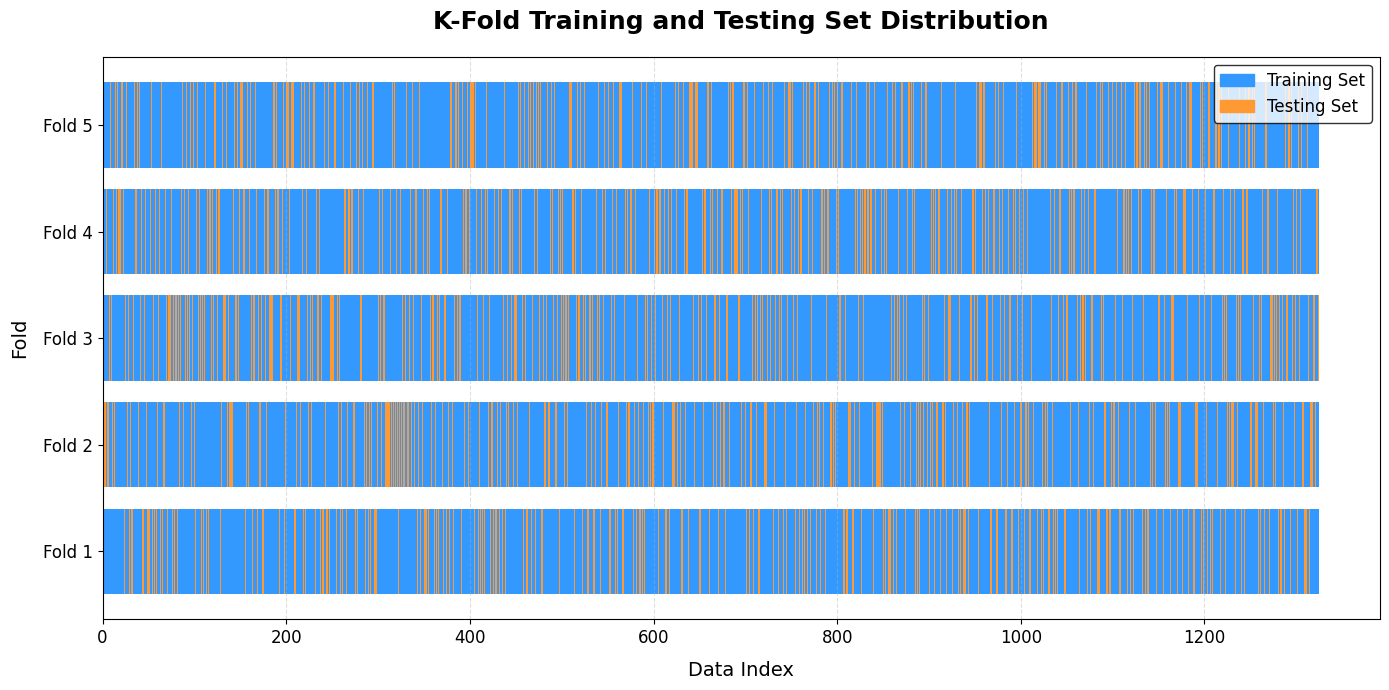

In [26]:
visualize_kfold_distribution(fold_data, num_folds)

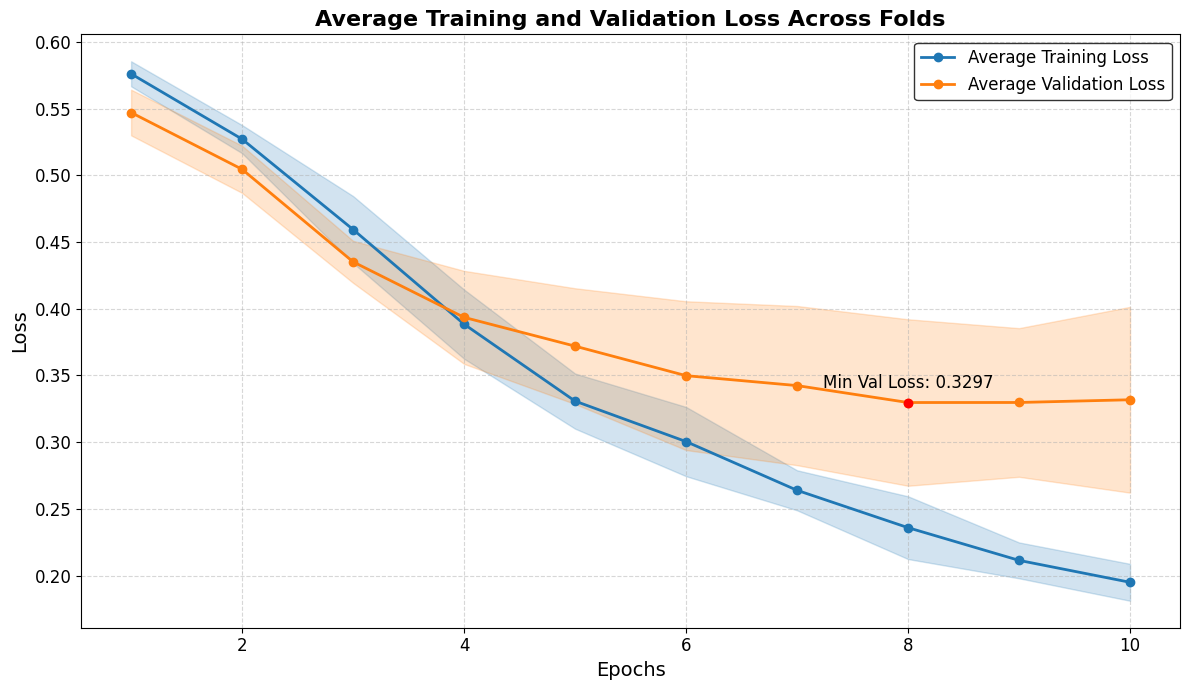

In [27]:
# Plot average loss curves across folds
plot_average_loss_curves(train_losses_folds, val_losses_folds)

In [28]:
df = pd.read_csv(f'results/gmu/GMU-CV_scores.csv')
df

,Metrics,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Loss,0.390802,0.438283,0.282895,0.263279,0.283449,0.331742
1,Accuracy,0.833962,0.807547,0.886792,0.898113,0.867925,0.858868
2,Precision,0.654321,0.586667,0.848485,0.872340,0.780000,0.748363
3,Recall,0.768116,0.687500,0.736842,0.661290,0.619048,0.694559
4,F1 Score,0.706667,0.633094,0.788732,0.752294,0.690265,0.714210
